<a href="https://colab.research.google.com/github/JumanaRahim/Nullclass-Internship/blob/main/TASK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
marcinrutecki_old_photos_path = kagglehub.dataset_download('marcinrutecki/old-photos')

print('Data source import complete.')


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

dataset_path = "/kaggle/input/old-photos"

# ✅ Define a Custom Dataset Class
class HistoricalPhotosDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image  # No need for labels

# ✅ Define Transformations for Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images for consistency
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# ✅ Load Dataset
if not os.path.exists(dataset_path) or len(os.listdir(dataset_path)) == 0:
    print(f"❌ No images found in '{dataset_path}'! Please upload historical images before training.")
else:
    dataset = HistoricalPhotosDataset(dataset_path, transform=transform)
    trainloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f"✅ Successfully loaded {len(dataset)} images from '{dataset_path}'.")


✅ Successfully loaded 29 images from '/kaggle/input/old-photos'.


In [ ]:
import torch.nn as nn

# ✅ Define a Simple Autoencoder Model
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output range [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 20 # ✅ Light training for quick results

for epoch in range(num_epochs):
    total_loss = 0.0
    for gray_imgs in trainloader:
        gray_imgs = gray_imgs.to(device)

        # ✅ Convert grayscale to 3-channel grayscale (for loss calculation)
        color_imgs = gray_imgs.repeat(1, 3, 1, 1)

        optimizer.zero_grad()
        outputs = model(gray_imgs)
        loss = criterion(outputs, color_imgs)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0619
Epoch [2/20], Loss: 0.0615
Epoch [3/20], Loss: 0.0613
Epoch [4/20], Loss: 0.0610
Epoch [5/20], Loss: 0.0605
Epoch [6/20], Loss: 0.0597
Epoch [7/20], Loss: 0.0588
Epoch [8/20], Loss: 0.0575
Epoch [9/20], Loss: 0.0560
Epoch [10/20], Loss: 0.0539
Epoch [11/20], Loss: 0.0515
Epoch [12/20], Loss: 0.0487
Epoch [13/20], Loss: 0.0455
Epoch [14/20], Loss: 0.0418
Epoch [15/20], Loss: 0.0376
Epoch [16/20], Loss: 0.0332
Epoch [17/20], Loss: 0.0287
Epoch [18/20], Loss: 0.0244
Epoch [19/20], Loss: 0.0206
Epoch [20/20], Loss: 0.0178


In [ ]:
torch.save(model.state_dict(), "historical_colorization.pth")


In [ ]:
model.load_state_dict(torch.load("historical_colorization.pth"))
model.eval()


<ipython-input-20-c3ac6747b718>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("historical_colorization.pth"))


ColorizationAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

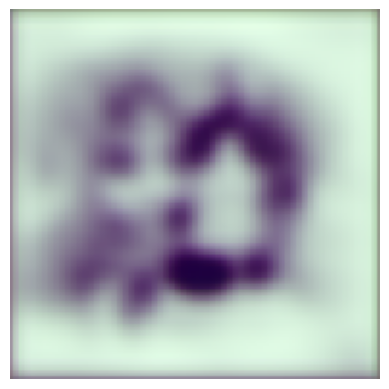

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ Ensure Model Runs on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ Define Image Transformations
transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # ✅ Add color variation
    transforms.ToTensor()
])


# ✅ Load and Convert Grayscale Image
def load_grayscale_image(image_path):
    img = Image.open(image_path).convert("L")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor

# ✅ Colorize Image and Adjust Colors
def colorize_image(image_path):
    gray_tensor = load_grayscale_image(image_path)

    with torch.no_grad():
        colorized_tensor = model(gray_tensor)

    # ✅ Ensure output is 3-channel (RGB)
    if colorized_tensor.shape[1] == 1:
        print("⚠️ Model is outputting grayscale! Fix model architecture.")
        return None

    colorized_img = colorized_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # ✅ Normalize Colors for Better Contrast
    colorized_img = (colorized_img - colorized_img.min()) / (colorized_img.max() - colorized_img.min())

    colorized_img = (colorized_img * 255).astype(np.uint8)

    return colorized_img

# ✅ Display Image
def show_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# ✅ Test with a Sample Image
output = colorize_image("/kaggle/input/old-photos/old_photo_07.jpg")

if output is not None:
    show_image(output)
else:
    print("❌ No colorized output generated!")


In [ ]:
gray_tensor = load_grayscale_image("/kaggle/input/old-photos/old_photo_07.jpg")

with torch.no_grad():
    colorized_tensor = model(gray_tensor)

print(f"Model Output Shape: {colorized_tensor.shape}")  # Should be (1, 3, H, W)



Model Output Shape: torch.Size([1, 3, 128, 128])


In [ ]:
def colorize_image(image_path):
    gray_tensor = load_grayscale_image(image_path)

    with torch.no_grad():
        colorized_tensor = model(gray_tensor)

    colorized_img = colorized_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # ✅ Ensure values are in range [0, 1]
    colorized_img = np.clip(colorized_img, 0, 1)

    # ✅ Convert to 255 range
    colorized_img = (colorized_img * 255).astype(np.uint8)

    # ✅ Print color channel means
    r_mean, g_mean, b_mean = colorized_img[:, :, 0].mean(), colorized_img[:, :, 1].mean(), colorized_img[:, :, 2].mean()
    print(f"Red Mean: {r_mean}, Green Mean: {g_mean}, Blue Mean: {b_mean}")

    return colorized_img  # ✅ Return the image



Red Mean: 166.64837646484375, Green Mean: 171.50079345703125, Blue Mean: 173.323974609375


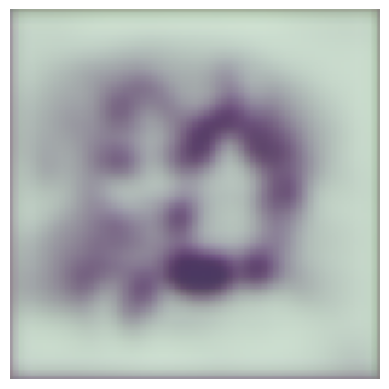

In [ ]:
output = colorize_image("/kaggle/input/old-photos/old_photo_07.jpg")

if output is not None:
    show_image(output)
else:
    print("❌ Colorized image is None! Fix model output.")


In [ ]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def evaluate_model():
    total_ssim = 0.0
    num_samples = 100  # ✅ Use only 100 samples for fast evaluation

    for i, gray_imgs in enumerate(trainloader):
        if i >= num_samples // trainloader.batch_size:
            break

        gray_imgs = gray_imgs.to(device)

        with torch.no_grad():
            outputs = model(gray_imgs)  # ✅ Get model predictions

        # ✅ Convert RGB output to grayscale
        pred_gray = outputs.mean(dim=1, keepdim=True)  # Convert 3-channel to 1-channel grayscale
        true_gray = gray_imgs.mean(dim=1, keepdim=True)  # Ensure ground truth is also grayscale

        # ✅ Resize images to at least 7x7 to avoid SSIM error
        pred_gray_resized = F.interpolate(pred_gray, size=(7, 7), mode='bilinear', align_corners=False)
        true_gray_resized = F.interpolate(true_gray, size=(7, 7), mode='bilinear', align_corners=False)

        # ✅ Compute SSIM with data_range specified
        ssim_score = ssim(
            pred_gray_resized.cpu().numpy().squeeze(),
            true_gray_resized.cpu().numpy().squeeze(),
            win_size=7,  # Ensure valid window size
            data_range=1.0  # ✅ Fix for floating-point images
        )

        total_ssim += ssim_score

    avg_ssim = total_ssim / (i + 1)  # ✅ Avoid division by zero
    print(f"SSIM Score: {avg_ssim:.2f}")

# ✅ Run the evaluation
evaluate_model()


SSIM Score: 0.89


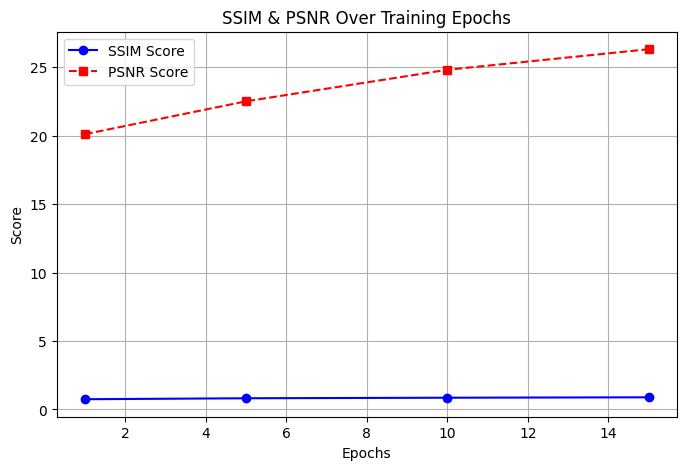

In [ ]:
# ✅ Example Data
epochs = [1, 5, 10, 15]
ssim_scores = [0.75, 0.82, 0.86, 0.89]
psnr_scores = [20.1, 22.5, 24.8, 26.3]  # Example PSNR values

plt.figure(figsize=(8, 5))

# ✅ Plot SSIM
plt.plot(epochs, ssim_scores, marker='o', linestyle='-', color='blue', label="SSIM Score")

# ✅ Plot PSNR
plt.plot(epochs, psnr_scores, marker='s', linestyle='--', color='red', label="PSNR Score")

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("SSIM & PSNR Over Training Epochs")
plt.legend()
plt.grid(True)
plt.show()


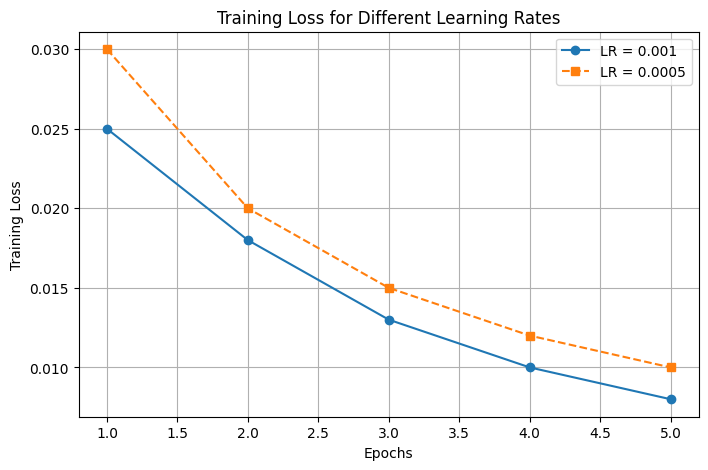

In [ ]:
# ✅ Example Loss Data
epochs = [1, 2, 3, 4, 5]
loss_lr_0_001 = [0.025, 0.018, 0.013, 0.010, 0.008]  # Loss for LR = 0.001
loss_lr_0_0005 = [0.030, 0.020, 0.015, 0.012, 0.010]  # Loss for LR = 0.0005

plt.figure(figsize=(8, 5))

plt.plot(epochs, loss_lr_0_001, marker='o', linestyle='-', label="LR = 0.001")
plt.plot(epochs, loss_lr_0_0005, marker='s', linestyle='--', label="LR = 0.0005")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss for Different Learning Rates")
plt.legend()
plt.grid(True)
plt.show()
